<a href="https://colab.research.google.com/github/jesuseedc/asl-dl/blob/main/SignDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# en caso de no estar instalado
!pip install mediapipe

     |████████████████████████████████| 36.1MB 1.8MB/s 


In [5]:
import cv2
import mediapipe as mp
import time
import numpy as np
import os
from tqdm.notebook import trange, tqdm
import pandas as pd
from sklearn import svm
from sklearn.externals import joblib
from google.colab.patches import cv2_imshow

# Necesario para utilizar la camara
from IPython.display import display, Javascript
from IPython.display import Image
from google.colab.output import eval_js
from base64 import b64decode

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [11]:
# En caso de no tener el dataset
!pip install kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d grassknoted/asl-alphabet

%ls

mv: cannot stat 'kaggle.json': No such file or directory
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)
asl-alphabet.zip  sample_data/


cp: 'asl-alphabet.zip' and './asl-alphabet.zip' are the same file


In [18]:
!unzip -q 'asl-alphabet.zip'

os.listdir()

['.config',
 'asl_alphabet_test',
 'asl_alphabet_train',
 'asl-alphabet.zip',
 'sample_data']

## Generación de los landmarks

In [20]:
mpHands = mp.solutions.hands
hands = mpHands.Hands()                 # Este objeto genera los landmarks
mpDraw = mp.solutions.drawing_utils     # Este los dibuja en la imagen

In [21]:
def GenerateSingleLandmarkFromFile(img_path):
    img = cv2.imread(img_path)
    landmarks = GenerateSingleLandmark(img)
    lm_vars = []

    if landmarks:
        for lm in landmarks[0].landmark:
            lm_vars.extend([lm.x, lm.y, lm.z])

    return (img_path[0], lm_vars)

def GenerateSingleLandmark(img):
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(imgRGB)

    return results.multi_hand_landmarks

def GenerateTrainingLandmarks(path, exclude_list=[]):
    os.chdir(path)
    dirlist = os.listdir()

    lm_dataset = {'X': [], 'y': []}

    for dir in tqdm(dirlist, desc='Convertion Progress'):
        if dir in exclude_list:
            continue
        
        os.chdir(dir)
        imlist = os.listdir()
        for im in tqdm(imlist, desc=f'{dir}', leave=None):
            label, landmarks_attr = GenerateSingleLandmarkFromFile(im)
            if landmarks_attr:
                lm_dataset['y'].append(label)
                lm_dataset['X'].append(landmarks_attr)
        os.chdir("..")
    
    return lm_dataset

def DrawLandmarks(img, landmarks=None):
    if landmarks == None:
        landmarks = GenerateSingleLandmark(img)

    if landmarks:
        for handlms in landmarks:
            mpDraw.draw_landmarks(img, handlms, mpHands.HAND_CONNECTIONS)

In [22]:
lm_dataset = GenerateTrainingLandmarks('/content/asl_alphabet_train/asl_alphabet_train', ['nothing'])

In [23]:
lm_df = pd.DataFrame(lm_dataset)

In [24]:
lm_df

,X,y
0,"[0.27535921335220337, 0.7770000696182251, -0.0...",C
1,"[0.3637940287590027, 0.3932623863220215, -5.07...",C
2,"[0.3708483874797821, 0.7141400575637817, -0.00...",C
3,"[0.28852128982543945, 0.5130452513694763, -8.3...",C
4,"[0.3206484317779541, 0.5527657270431519, -4.78...",C
...,...,...
63345,"[0.33748096227645874, 0.6488425731658936, 2.34...",d
63346,"[0.7151983380317688, 0.5579627752304077, 5.381...",d
63347,"[0.45771607756614685, 0.7145891189575195, 6.15...",d
63348,"[0.16686315834522247, 0.6502266526222229, -4.0...",d


In [27]:
lm_df.to_csv("./LandmarksDataset.csv")


In [28]:
clf = svm.SVC()
y_train = lm_df['y'].to_list()
X_train = lm_df['X'].to_list()

In [29]:
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
def GenerateTestLandmarks(path, exclude=[]):
    os.chdir(path)
    imlist = os.listdir()

    lm_test_dataset = {'X': [], 'y': []}
        
    for im in tqdm(imlist, desc='image'):
        if im in exclude:
            continue

        label, lm_vars = GenerateSingleLandmarkFromFile(im)
        if lm_vars:
            lm_test_dataset['y'].append(label)
            lm_test_dataset['X'].append(lm_vars)
    
    return lm_test_dataset

In [31]:
lm_test_dataset = GenerateTestLandmarks('/content/asl_alphabet_test/asl_alphabet_test', 'nothing_test.jpg')

In [32]:
print(lm_test_dataset['y'])
clf.predict(lm_test_dataset['X'])

['S', 's', 'O', 'B', 'X', 'L', 'P', 'U', 'K', 'Z', 'V', 'D', 'N', 'F', 'J', 'T', 'M', 'W', 'Q', 'C', 'Y']


array(['S', 's', 'O', 'B', 'X', 'L', 'Q', 'U', 'K', 'Z', 'V', 'D', 'N',
       'F', 'J', 'T', 'M', 'W', 'Q', 'C', 'Y'], dtype='<U1')

In [34]:
!mkdir /Models

In [35]:
joblib.dump(clf,"/Models/sign_decoder_svm.pkl")

['/Models/sign_decoder_svm.pkl']

In [36]:
!ls /Models

sign_decoder_svm.pkl


## Parte interactiva con la camara

### codigo para usar la camara desde colab

In [37]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


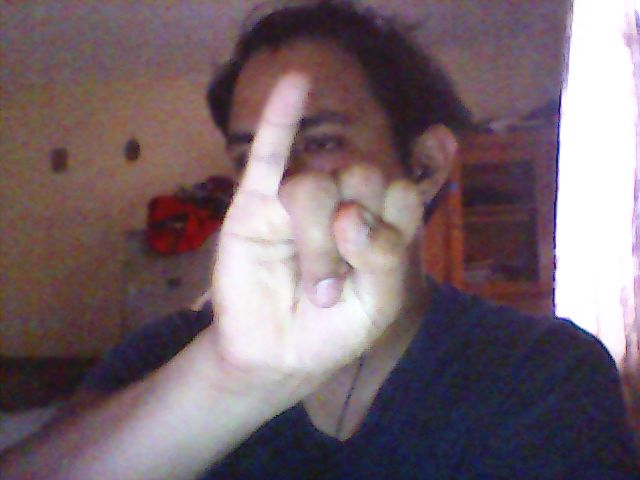

In [50]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Generando los ladnmarks de la imagen

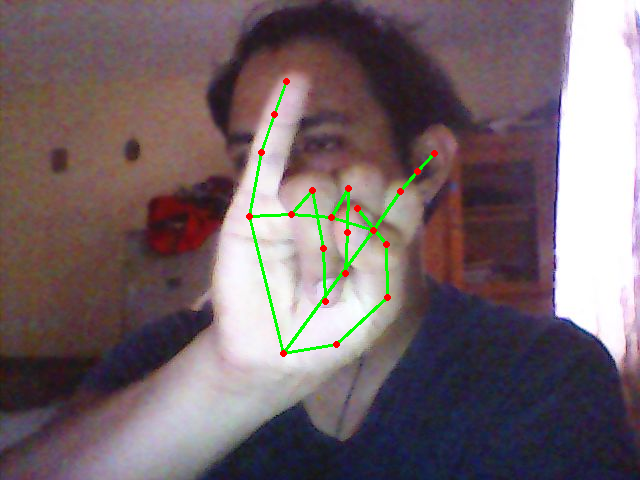

In [51]:
img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
DrawLandmarks(img)
cv2_imshow(img)

### Cargamos el modelo en caso de no estar cargado

In [45]:
clf = joblib.load("/Models/sign_decoder_svm.pkl")

In [52]:
_, landmarks = GenerateSingleLandmarkFromFile('photo.jpg')
clf.predict([landmarks])

array(['I'], dtype='<U1')